<a href="https://colab.research.google.com/github/fedhere/DSPS_FBianco/blob/main/HW6/DSPS_gaussian_process_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Willow Fox Fortrino, Federica Bianco, Christian Munley @UDel.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino
from scipy.optimize import minimize

!pip install george
import george
from george import kernels

# 0. Load The Dataset

We'll be using the El Niño dataset from the `statsmodels` package. Description of the dataset [here](https://www.statsmodels.org/devel/datasets/generated/elnino.html).

In [9]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()
# df

In [10]:
def flatten_dataset(df):
    """
    Transform a structured dataset of sea surface temperatures into a flat structure.

    The function takes a dataframe where each row represents a year (from 1950 to 2010), and each column
    represents a month. It then transforms this structure into two 1-dimensional arrays: one for time and
    one for the sea surface temperature data.

    Parameters
    ----------
    df : pd.DataFrame
        A pandas dataframe where rows are years, columns are months, and values are sea surface temperatures.

    Returns
    -------
    time : list of str
        A list of time labels in the format "Month Year", representing every month from January 1950 to December 2010.
    data : numpy.ndarray
        A 1-dimensional array of sea surface temperature data corresponding to the times in the 'time' list.
    """
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    time = []
    for year in range(1950, 2011):
        for month in months:
            time.append(f'{month} {year}')
    data = df.iloc[:, 1:].to_numpy().flatten()
    return time, data

x, y = flatten_dataset(df)

# 1. Visualize the data

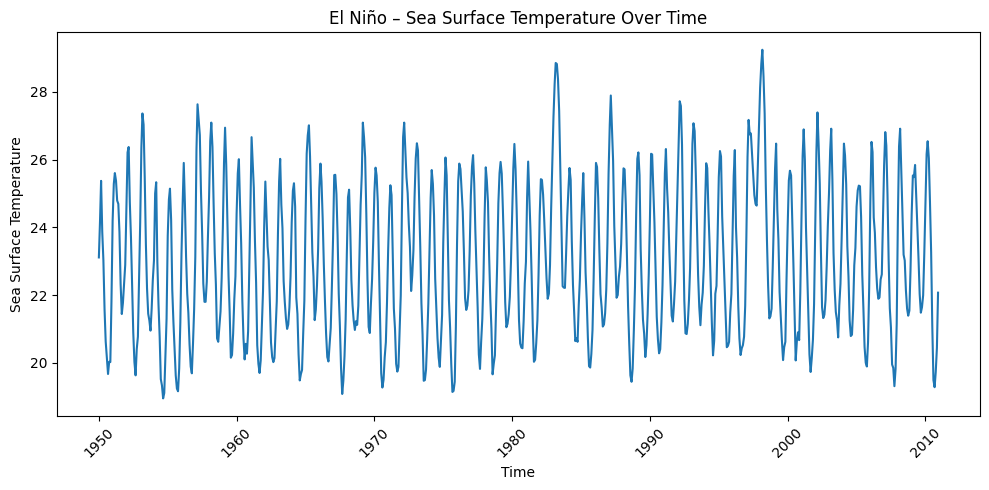

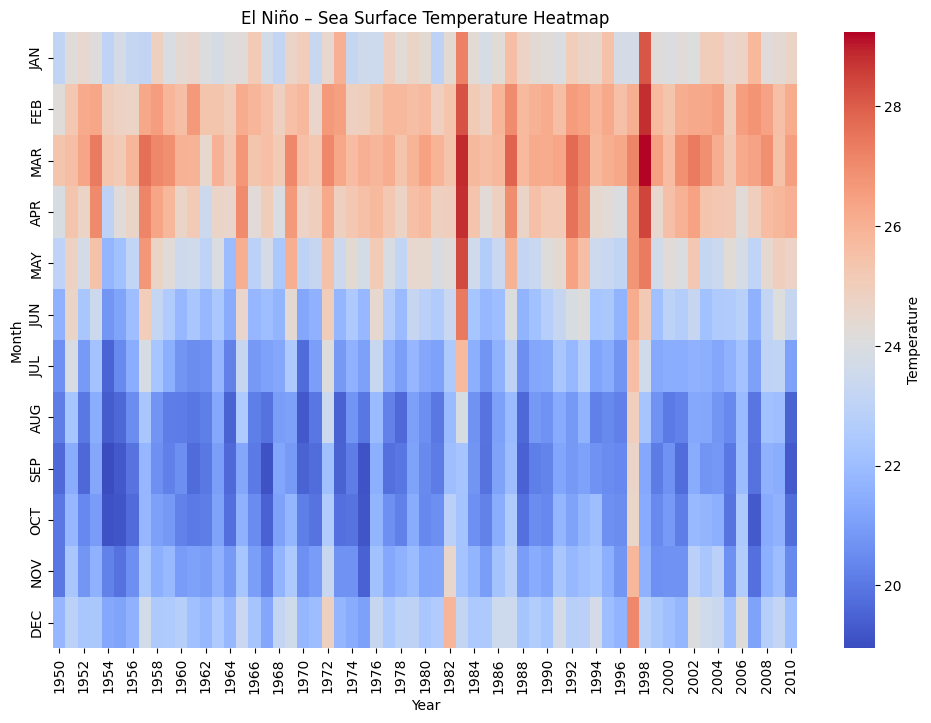

In [11]:
def visualize(df):
    """
    Visualize the sea surface temperature dataset using a line plot and a heatmap.

    The function provides two visualizations:
    1. A line plot that shows the sea surface temperature changes over time.
    2. A heatmap that depicts the variation of temperature across months and years.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset.

    Returns
    -------
    None
    """
    # Flatten the dataset
    time, data = flatten_dataset(df)
    plot_df = pd.DataFrame({
        'Time': pd.to_datetime(time, format='%B %Y'),
        'Temperature': data
    })

    # Line plot for Sea Surface Temperature over time
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=plot_df, x='Time', y='Temperature')
    plt.title('El Niño – Sea Surface Temperature Over Time')
    plt.xlabel('Time')
    plt.ylabel('Sea Surface Temperature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Heatmap for visualizing temperature across months and years
    heatmap_data = df.iloc[:, 1:].copy()
    heatmap_data.index = range(1950, 2011)
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data.T, cmap='coolwarm', cbar_kws={'label': 'Temperature'})
    plt.title('El Niño – Sea Surface Temperature Heatmap')
    plt.xlabel('Year')
    plt.ylabel('Month')
    plt.show()

visualize(df)

### Figure 1: Visualization of the El Niño Sea Surface Temperature Dataset over time through lineplot and heatmap. The line plot shows the variation in sea surface temperature over time, montly from 1950 to 2010. The x-axis represents the time and the y-axis is the temperature. The line plot captures the periodic events and makes spikes noticeable. The heatmap x-axis represents the years, and the y-axis represents the months, and the color intensity represents the sea surface temperature. The visualization aids in identifying patterns and cyclical neture of the data, and makes it easy to spot years with unusually high temperatures.


# 2. Gaussian Process Regression (GPR)

In [12]:
def get_interpolated_time():
    """
    Create an array of time points for each day between January 1st, 1950 and December 1st, 2030.

    The function generates a range of dates, creating an entry for each day within the specified range.

    Parameters
    ----------
    None

    Returns
    -------
    interp_time : pandas.DatetimeIndex
        An array of time points, each representing a day from January 1st, 1950 to December 1st, 2030.
    """
    interp_time = pd.date_range(start="1950-01-01", end="2030-12-01", freq='D')
    return interp_time

interp_time = get_interpolated_time()
data_time = pd.to_datetime(x, format='%B %Y')
time_numeric = (data_time - data_time.min()).days.values.reshape(-1, 1)
interp_time_numeric = (interp_time - data_time.min()).days.values.reshape(-1, 1)
# interp_time
# time_numeric

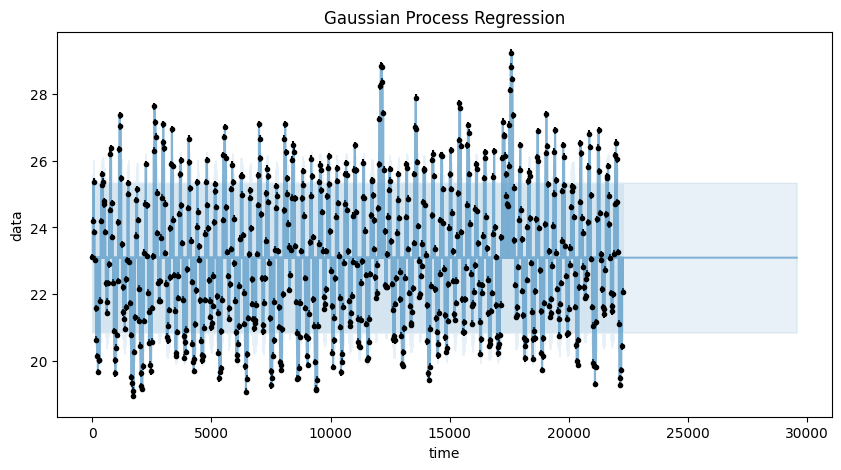

In [13]:
def gaussian_process_regression(time, data, interp_time, initial_guess):
    """
    Apply Gaussian Process Regression (GPR) to sea surface temperature data and predict values for specified time points.

    The function takes in the sea surface temperature data, applies GPR using the george library, and predicts the
    sea surface temperature for an array of interpolated time points.

    Parameters
    ----------
    time : numpy.ndarray
        A 1-dimensional array representing the numerical representation of time for the observed data.
    data : numpy.ndarray
        A 1-dimensional array of observed sea surface temperatures.
    interp_time : numpy.ndarray
        A 1-dimensional array of numerical time points for which predictions are to be made.
    initial_guess : array-like
        Initial hyperparameter guesses for the Gaussian Process.

    Returns
    -------
    pred : numpy.ndarray
        The predictive mean of the Gaussian Process model at the interpolated time points.
    pred_var : numpy.ndarray
        The predictive variance of the Gaussian Process model at the interpolated time points.
    """
    # Radial Kernel (RBF)
    kernel = np.var(data) * kernels.ExpSquaredKernel(0.5)

    # Gaussian Process object
    gp = george.GP(kernel, mean=np.mean(data))
    gp.compute(time, yerr=0)

    # Predict
    pred, pred_var = gp.predict(data, interp_time, return_var=True)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.errorbar(time, data, 0.1, fmt=".k", capsize=0)
    plt.plot(interp_time.flatten(), pred, "C0", alpha=0.5)
    plt.fill_between(interp_time.flatten(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="C0", alpha=0.1)
    plt.xlabel("time")
    plt.ylabel("data")
    plt.title("Gaussian Process Regression")
    plt.show()

    return pred, pred_var

initial_guess = [2, 2]
a,b = gaussian_process_regression(time_numeric, y, interp_time_numeric, initial_guess)

### Figure 2: Gaussion Process Regression on Sea Surface Termperatures using the Radial Basis Function kernel with an intial parameter guess. The dataset is showsn as black dots, representing monthly temperature measurements, while blue line and shaded region depict the predictive mean and uncertainty of the GPR model extrapolated to 2030. The predictions stay at the mean beyond the data cutoff as the RBF is a stationary kernel and cannot extrapolate in this way. The visualization is useful for examining the model performance and showcasing its ability to capture the underlying trend of the data. It also can highlight regions of increased uncertainty due to variability or scarcity in the data.

# 3. Optimize the model

In [14]:
def optimize(time, data):
    """
    Optimize the hyperparameters of a Gaussian Process Regression model for sea surface temperature data.

    The function creates a Gaussian Process Regression model, defines the negative log likelihood as the
    objective function for optimization, and uses a gradient descent algorithm to find the optimal set
    of hyperparameters that minimize the negative log likelihood.

    Parameters
    ----------
    time : numpy.ndarray
        A 1-dimensional array representing the numerical representation of time for the observed data.
    data : numpy.ndarray
        A 1-dimensional array of observed sea surface temperatures.

    Returns
    -------
    gp : george.GP
        The Gaussian Process Regression model with optimized hyperparameters.
    """
    # Define the kernel with initial hyperparameters.
    initial_params = [np.var(data), .5]
    kernel = initial_params[0] * kernels.ExpSquaredKernel(initial_params[1])

    # Create a Gaussian Process object.
    gp = george.GP(kernel, mean=np.mean(data))

    # Pre-compute the factorization of the matrix.
    gp.compute(time, yerr=0)

    # Define the objective function (negative log likelihood in this case).
    def neg_log_like(params, gp, y):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    # Define the gradient of the objective function.
    def grad_neg_log_like(params, gp, y):
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y)

    # Optimize the hyperparameters.
    result = minimize(neg_log_like, gp.get_parameter_vector(), jac=grad_neg_log_like, args=(gp, data))

    # Update the kernel with the optimized hyperparameters.
    gp.set_parameter_vector(result.x)

    # Print the results.
    print("Optimization Result:", result)
    print("Optimized log likelihood:", -result.fun)
    print("Optimized hyperparameters:", np.exp(result.x))  # since george uses the log of the parameters

    return gp

gp = optimize(time_numeric, y)

Optimization Result:   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1630.4294051351228
        x: [ 1.617e+00 -6.931e-01]
      nit: 0
      jac: [ 9.080e-11 -0.000e+00]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 1
     njev: 1
Optimized log likelihood: -1630.4294051351228
Optimized hyperparameters: [5.03718848 0.5       ]


# 4. Visualize the optimized model

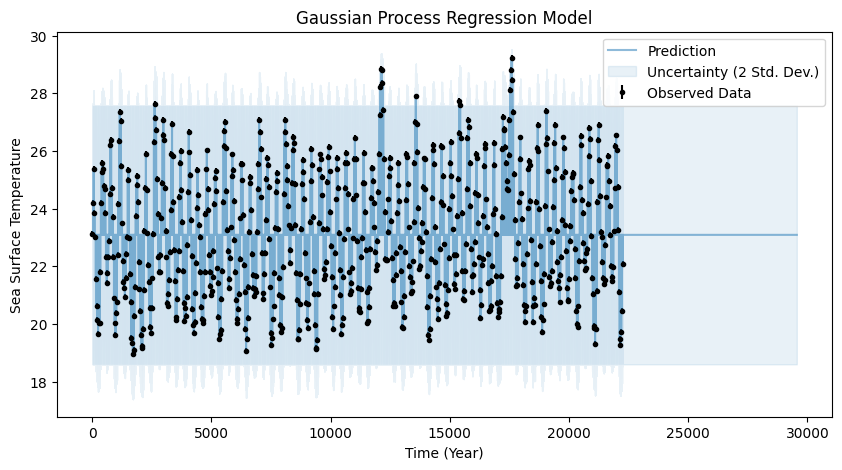

In [15]:
def visualize_model(gp, time, data, interp_time, pred, pred_var):
    """
    Visualize the Gaussian Process Regression model.

    Generates visualizations to represent the Gaussian Process Regression model's predictions,
    including observed data, predictions, and uncertainty.

    Parameters
    ----------
    gp : george.GP
        The trained Gaussian Process model.
    time : array-like
        The time points corresponding to the observed data.
    data : array-like
        The observed sea surface temperatures.
    interp_time : array-like
        The time points for which predictions have been made.
    pred : array-like
        The predictive mean of the Gaussian Process model.
    pred_var : array-like
        The predictive variance of the Gaussian Process model.

    Returns
    -------
    None
    """
    plt.figure(figsize=(10, 5))

    # Observed data
    plt.errorbar(time, data, 0.1, fmt=".k", capsize=0, label='Observed Data')

    # Predictions
    plt.plot(interp_time, pred, "C0", alpha=0.5, label='Prediction')

    # Uncertainty (2 standard deviations)
    uncertainty = 2 * np.sqrt(pred_var)
    interp_time_flat = np.ravel(interp_time)
    plt.fill_between(interp_time_flat, pred - uncertainty, pred + uncertainty, color="C0", alpha=0.1, label='Uncertainty (2 Std. Dev.)')

    # Labels and title
    plt.xlabel("Time (Year)")
    plt.ylabel("Sea Surface Temperature")
    plt.title("Gaussian Process Regression Model")
    plt.legend()

    plt.show()

visualize_model(gp, time_numeric, y, interp_time_numeric, a,b)

### Figure 3: Optimized Gaussion Process Regression Model for Sea Surface Temperatures. The blue line indicates the GPR predictive mean after hyperparameter optimization, with the light blue shaded area illustrating the predictive uncertainty at two standard deviations. The optimization process has fine-tuned the model's hyperparameters to better capture the underlying trends and variability in the data, resulting in a more accurate and reliable prediction. The graph provides a comprehensive view of the model's performance across time, emphasizing regions where the model is more certain (narrower shaded area) and areas with higher uncertainty (wider shaded area). This optimized model serves as a tool for understanding and predicting sea surface temperature variations, crucial for studying climate phenomena such as El Niño.